TEAM benchmark 7
===

https://www.compumag.org/wp/wp-content/uploads/2018/06/problem7.pdf

Solve
\begin{align*}
\nabla\times(\nu\nabla\times\mathbf{A}) + j\omega\sigma \mathbf{A} = \mathbf{J}
\end{align*}
with
\begin{align*}
\mathbf{A}\times\mathbf{n} = \mathbf{0}
\end{align*}
on the far boundary. The magnetic permability $\mu_0 =\nu_0^{-1} = 4\pi \cdot 10^{-7}$ H/m  is set to the permability of vacuum and the electric conductivity $\sigma_{Al} = 3.526\cdot10^7$ S/m in the aluminum plate is used.


In [1]:
from netgen.occ import *
from ngsolve import *
from ngsolve.webgui import Draw
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
from netgen.meshing import MeshingParameters

In [2]:
def assert_almost_eqaul(a, b, rel_eps=1e-8):
    assert abs((a - b)/(a)) < rel_eps, f"a: {a}, b: {b}\neps: {abs((a - b)/(a))} > {rel_eps}"

## Generate Geometry

In [3]:
xi_msm = np.array([0, 18, 36, 54, 72, 90, 108, 126, 144, 162, 180, 198, 216, 234, 252, 270, 288]) * 1e-3

The aluminum plate:

In [4]:
plate = Box(Pnt(0, 0, 0), Pnt(0.294, 0.294, 0.019)) 
plate.name="plate"
plate -= Box(Pnt(0.018, 0.018, -0.1), Pnt(0.126, 0.126, 0.1))
plate.faces.maxh=0.01
plate.faces.col=(0.3,0.3,0.3)

# alternative: less hand calculation
wpplate = WorkPlane(Axes((0,0,0),Z,X))
f = wpplate.Rectangle(0.294,0.294).MoveTo(0.018,0.018).Rectangle(0.108,0.108).Reverse().Face()
plate2 = f.Extrude(0.019)
plate2.faces.maxh=0.1

The coil:

In [5]:
wp = WorkPlane(Axes(p=(0.294,0.000,0.049), n=Z, h=Y)) # origin in 
coil2DCorner = (wp.Rectangle(0.050, 0.050).Face() * wp.MoveTo(0.050, 0.050).Circle(0.050).Face() - wp.Circle(0.025).Face()) 
coil2DLimb = wp.MoveTo(0.050, 0).Rectangle(0.100, 0.025).Face()
coil2DCorner.faces.name = "coil_corner"
coil2DLimb.faces.name = "coil_limb"
coil2Dpart = Glue([coil2DCorner, coil2DLimb])
ax = Axis(p=(0.194,0.100,0.049), d=(0, 0, 1))
coil2D = Glue([coil2Dpart.Rotate(ax, ang) for ang in [0, 90, 180, 270]])
coil = coil2D.Extrude(0.100)
#Draw(coil)

In [6]:
bounding_box = Box(Pnt(-.2, -.2, -.2), Pnt(0.5, 0.5, 0.5))
bounding_box.faces.Max(X).name="right"
bounding_box.faces.Min(X).name="left"
bounding_box.faces.Max(Y).name="back"
bounding_box.faces.Min(Y).name="front"
bounding_box.faces.Max(Z).name="top"
bounding_box.faces.Min(Z).name="bottom"
bounding_box.name="air"

bounding_box = bounding_box-coil- plate

In [7]:
geo = OCCGeometry(Glue([bounding_box, coil, plate]))

Restrict around measerung points

In [8]:
mp = MeshingParameters ( maxh =1)
# for A1B1 measurement
[mp.RestrictH(x, 0.072, 0.034, h= 0.01/3) for x in xi_msm];
# for A2B2 measurement
[mp.RestrictH(x, 0.144, 0.034, h= 0.01/3) for x in xi_msm];
# for A3B3 measurement
[mp.RestrictH(x, 0.072, 0.019, h= 0.01/3) for x in xi_msm];
# for A4B4 measurement
[mp.RestrictH(x, 0.072, 0.000, h= 0.01/3) for x in xi_msm];


In [9]:
mesh = Mesh(geo.GenerateMesh(maxh=0.1, mp=mp))
mesh.Curve(3)
print("mats", set(mesh.GetMaterials()))
print("number of elements", mesh.ne)
clipping_settings={"Clipping":{"enable":True, "z":-1, "dist":0}}
if True:
    Draw(mesh, settings = clipping_settings);

mats {'plate', 'coil_corner', 'coil_limb', 'air'}
number of elements 74281


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Clipping': {'enable': True, …

## Assert Geometry

In [10]:
Vol_coil_should = 0.100 * (0.025*0.100*4 + (0.050**2-0.025**2) * np.pi)
Vol_plate_should = 0.019 * (0.294*0.294-0.108*0.108)

assert_almost_eqaul(Integrate(1, mesh, definedon=mesh.Materials("coil.*")),  Vol_coil_should, rel_eps=1e-5)
assert_almost_eqaul(Integrate(1, mesh, definedon=mesh.Materials("plate.*")),  Vol_plate_should, rel_eps=1e-5)

## Define Current in Coil

In [11]:

coilrect_xmin, coilrect_xmax = 0.294 - 0.150, 0.294-0.050
coilrect_ymin, coilrect_ymax = 0.050, 0.150

def Project(val, minval, maxval):
    return IfPos(val-minval, IfPos(val-maxval, maxval, val), minval)

projx = Project(x, coilrect_xmin, coilrect_xmax)
projy = Project(y, coilrect_ymin, coilrect_ymax)
Jtau = CF( (projy-y, x-projx, 0) )
Jtau /= Norm(Jtau)
J_coil = mesh.MaterialCF({"coil.*":Jtau}, default=CF((0, 0, 0)))


In [12]:
clipping_settings={"Clipping":{"enable":True, "z":-1, "dist":-0.05}, "Objects":{"Clipping Plane":False, "Vectors":True}, "Vectors":{"grid_size":100}}
clipping_settings.update({"camera":{"transformations":[{"type":"move", "dir":(0,0,1), "dist":1.9}]}})
Draw(J_coil, mesh,settings=clipping_settings, draw_surf=False); # top right, mesh, settings=clipping_settings)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Clipping': {'enable': True, …

## FEM

In [13]:
mu = 4e-7*np.pi
sigma = mesh.MaterialCF({"plate":3.526e7}, default=1)

freq = Parameter(50)
order0 = 1

In [14]:
J0 = 2742 / (0.025 * 0.100)
print(f"J0{J0} A/m**2")
omega = freq * np.pi * 2

def calc_it():
    fesA = HCurl(mesh, order=order0, dirichlet="top|back|right", complex=True)
    print("free dofs", sum(fesA.FreeDofs()))
    u, v = fesA.TnT()
    A = GridFunction(fesA, "A")
    B = curl(A)
    J = -sigma * 1j * omega * A
    
    a = BilinearForm(fesA, symmetric=True)
    a += 1/mu * curl(u) * curl(v) * dx
    if freq.Get() > 0:
        a += 1j* omega * sigma * u *v * dx
    else:
        # regularisation
        a += 1 * u * v * dx
    
    f = LinearForm(fesA)
    f += -J0*J_coil*v * dx("coil.*")
    
    pre = Preconditioner(a, type="direct", inverse="sparsecholesky")
    with TaskManager():
        solvers.BVP(bf=a, lf = f, pre=pre, gf=A)

    return {"A":A, "B":B, "J":J}

with TaskManager():
    ret = calc_it()
B, J = ret["B"], ret["J"]

J01096799.9999999998 A/m**2
free dofs 173802
CG iteration 1, residual = 1.2394170147318768     
CG iteration 2, residual = 2.398854083590101e-07     
CG iteration 3, residual = 4.424488344928656e-13     


## Draw the B and J field

In [15]:
clipping_settings={"Clipping":{"enable":True, "y":1, "z":0, "dist":0.1}, "Objects":{"Clipping Plane":False, "Vectors":True}, "Vectors":{"grid_size":100}}

clipping_settings.update({"camera":{"transformations":[{"type":"rotateX", "angle":-90}, {"type":"move", "dir":(0,0,1.5), "dist":1}]}})
Draw(B.real, mesh, settings=clipping_settings, max = 10e-3, min = 0);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Clipping': {'enable': True, …

In [16]:
clipping_settings={"Clipping":{"enable":True, "y":0, "z":-1, "dist":-0.132}, "Objects":{"Clipping Plane":False, "Vectors":True}, "Vectors":{"grid_size":150}}

clipping_settings.update({"camera":{"transformations":[{"type":"move", "dir":(0,0,1), "dist":2.2}]}})
Draw(mesh.MaterialCF({"plate":J.imag}, default = CF((0, 0, 0))), mesh, settings = clipping_settings, min = 0, max = 8e5);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Clipping': {'enable': True, …

## Evaluation of B and J according to Description

In [17]:
Bz_A1B1_50Hz_ref = np.array([ -4.9  -1.16j, -17.88 +2.48j, -22.13 +4.15j, -20.19 +4.j,   -15.67 +3.07j,
   0.36 +2.31j,  43.64 +1.89j,  78.11 +4.97j,  71.55+12.61j , 60.44+14.15j,
  53.91+13.04j,  52.62+12.4j,  53.81+12.05j, 56.91+12.27j,  59.24+12.66j,
  52.78 +9.96j,  27.61 +2.26j])
               
Bz_A2B2_50Hz_ref = np.array([-1.83-1.63j, -8.5-0.6j, -13.6-0.43j, -15.21+0.11j, -14.48+1.26j, -5.62+3.4j,
 28.77+6.53j, 60.34+10.25j, 61.84+11.83j, 56.64+11.83j, 53.4+11.01j, 52.36+10.58j, 53.93+10.8j, 56.82+10.54j, 
 59.48+10.62j, 52.08+9.03j, 26.56+1.79j])

Jy_A3B3_50Hz_ref = np.array([0.249-0.629j,  0.685-0.873j,  0+0j,  0+0j,  0+0j,  0+0j,  0+0j,  -0.015-0.593j,
             -0.103-0.249j,  -0.061-0.101j,  -0.004-0.001j,  0.051+0.087j,  0.095+0.182j,  0.135+0.322j,  
             0.104+0.555j,  -0.321+0.822j,  -0.687+0.855j,])


Jy_A4B4_50Hz_ref = np.array([0.461-0.662j,  0.621-0.664j,  0+0j,  0+0j,  0+0j,  0+0j,  0+0j,  1.573-1.027j,
             0.556-0.757j,  0.237-0.364j,  0.097-0.149j,  -0.034+0.015j,  -0.157+0.154j,  -0.305+0.311j,
             -0.478+0.508j,  -0.66+0.747j,  -1.217+1.034j])


### Bz on A1 to B1

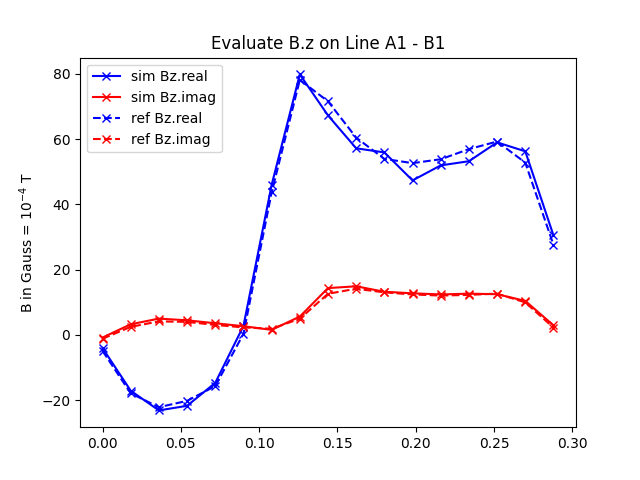

In [18]:
Bz_A1B1 = np.array([B[2](mesh(x, 0.072, 0.034)) for x in xi_msm])

plt.figure(1)
plt.clf()
plt.title("Evaluate B.z on Line A1 - B1")
plt.plot(xi_msm, -1e4 * Bz_A1B1.real, "b-x", label="sim Bz.real")
plt.plot(xi_msm, 1e4 * Bz_A1B1.imag, "r-x", label="sim Bz.imag")
plt.plot(xi_msm, Bz_A1B1_50Hz_ref.real, "b--x", label="ref Bz.real")
plt.plot(xi_msm, Bz_A1B1_50Hz_ref.imag, "r--x", label="ref Bz.imag")
plt.ylabel("B in Gauss = $10^{-4}$ T")
plt.legend()
plt.show()

### Bz on A2 to B2

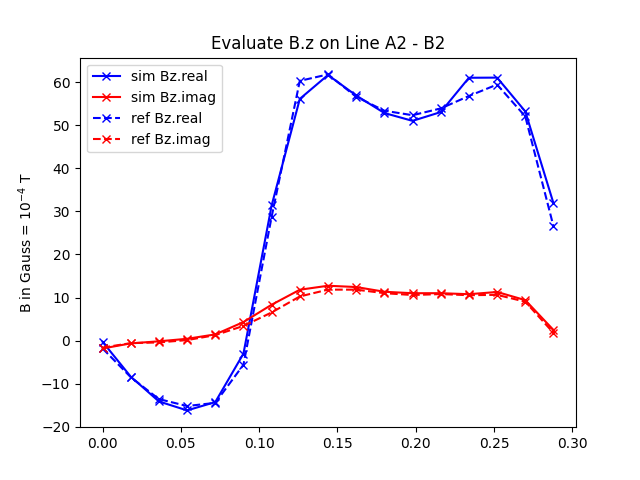

In [19]:
Bz_A2B2 = np.array([B[2](mesh(x, 0.144, 0.034)) for x in xi_msm])

plt.figure(2)
plt.clf()
plt.title("Evaluate B.z on Line A2 - B2")
plt.plot(xi_msm, -1e4 * Bz_A2B2.real, "b-x", label="sim Bz.real")
plt.plot(xi_msm, 1e4 * Bz_A2B2.imag, "r-x", label="sim Bz.imag")
plt.plot(xi_msm, Bz_A2B2_50Hz_ref.real, "b--x", label="ref Bz.real")
plt.plot(xi_msm, Bz_A2B2_50Hz_ref.imag, "r--x", label="ref Bz.imag")
plt.ylabel("B in Gauss = $10^{-4}$ T")
plt.legend()
plt.show()

### Jy on A3 to B3

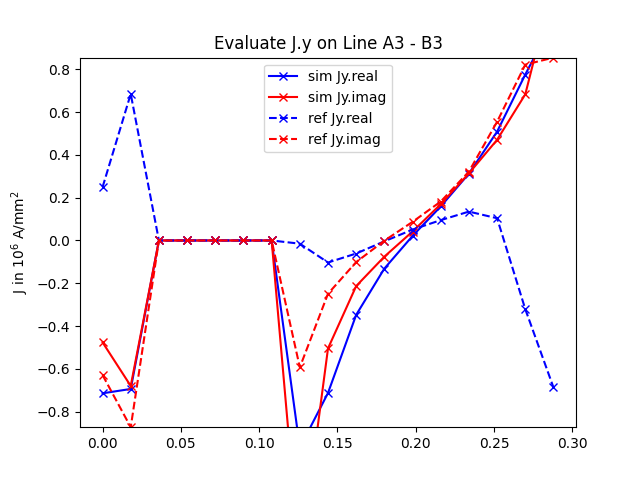

In [20]:
Jy_A3B3 = np.array([J[1](mesh(x, 0.072, 0.019-1e-5)) for x in xi_msm])

plt.figure(3)
plt.clf()
plt.title("Evaluate J.y on Line A3 - B3")
plt.plot( xi_msm, 1e-6 *Jy_A3B3.real, "b-x", label="sim Jy.real")
plt.plot( xi_msm, 1e-6 * Jy_A3B3.imag, "r-x", label="sim Jy.imag")
plt.plot(xi_msm, Jy_A3B3_50Hz_ref.real, "b--x", label="ref Jy.real")
plt.plot(xi_msm, Jy_A3B3_50Hz_ref.imag, "r--x", label="ref Jy.imag")
plt.ylabel("J in $10^{6}$ A/mm$^2$")
plt.ylim([min(list(Jy_A3B3_50Hz_ref.real)+list(Jy_A3B3_50Hz_ref.imag)), max(list(Jy_A3B3_50Hz_ref.real)+list(Jy_A3B3_50Hz_ref.imag))])
plt.legend()
plt.show()

### Jy on A4 to B4

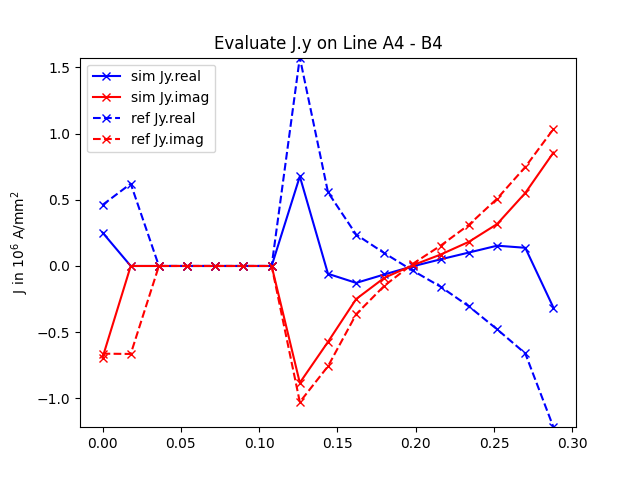

In [21]:
Jy_A4B4 = np.array([J[1](mesh(x, 0.072, 0.0+1e-3)) for x in xi_msm])

plt.figure(4)
plt.clf()
plt.title("Evaluate J.y on Line A4 - B4")
plt.plot( xi_msm, - 1e-6 *Jy_A4B4.imag, "b-x", label="sim Jy.real")
plt.plot( xi_msm, 1e-6 * Jy_A4B4.real, "r-x", label="sim Jy.imag")
plt.plot(xi_msm, Jy_A4B4_50Hz_ref.real, "b--x", label="ref Jy.real")
plt.plot(xi_msm, Jy_A4B4_50Hz_ref.imag, "r--x", label="ref Jy.imag")
plt.ylabel("J in $10^{6}$ A/mm$^2$")
plt.ylim([min(list(Jy_A4B4_50Hz_ref.real)+list(Jy_A4B4_50Hz_ref.imag)), max(list(Jy_A4B4_50Hz_ref.real)+list(Jy_A4B4_50Hz_ref.imag))])
plt.legend()
plt.show()